In [ ]:
!pip install geopandas folium


Saving Data - India.csv to Data - India.csv
   CountryName CountryCode                   RegionName RegionCode  \
60       India         IND  Andaman and Nicobar Islands     IND_AN   
61       India         IND  Andaman and Nicobar Islands     IND_AN   
62       India         IND  Andaman and Nicobar Islands     IND_AN   
63       India         IND  Andaman and Nicobar Islands     IND_AN   
64       India         IND  Andaman and Nicobar Islands     IND_AN   

   Jurisdiction       Date  C1_School closing  C1_Flag  C2_Workplace closing  \
60  STATE_TOTAL 2020-03-01                NaN      NaN                   NaN   
61  STATE_TOTAL 2020-03-02                NaN      NaN                   NaN   
62  STATE_TOTAL 2020-03-03                NaN      NaN                   NaN   
63  STATE_TOTAL 2020-03-04                NaN      NaN                   NaN   
64  STATE_TOTAL 2020-03-05                NaN      NaN                   NaN   

    C2_Flag  ...  ConfirmedDeaths  StringencyIndex  St

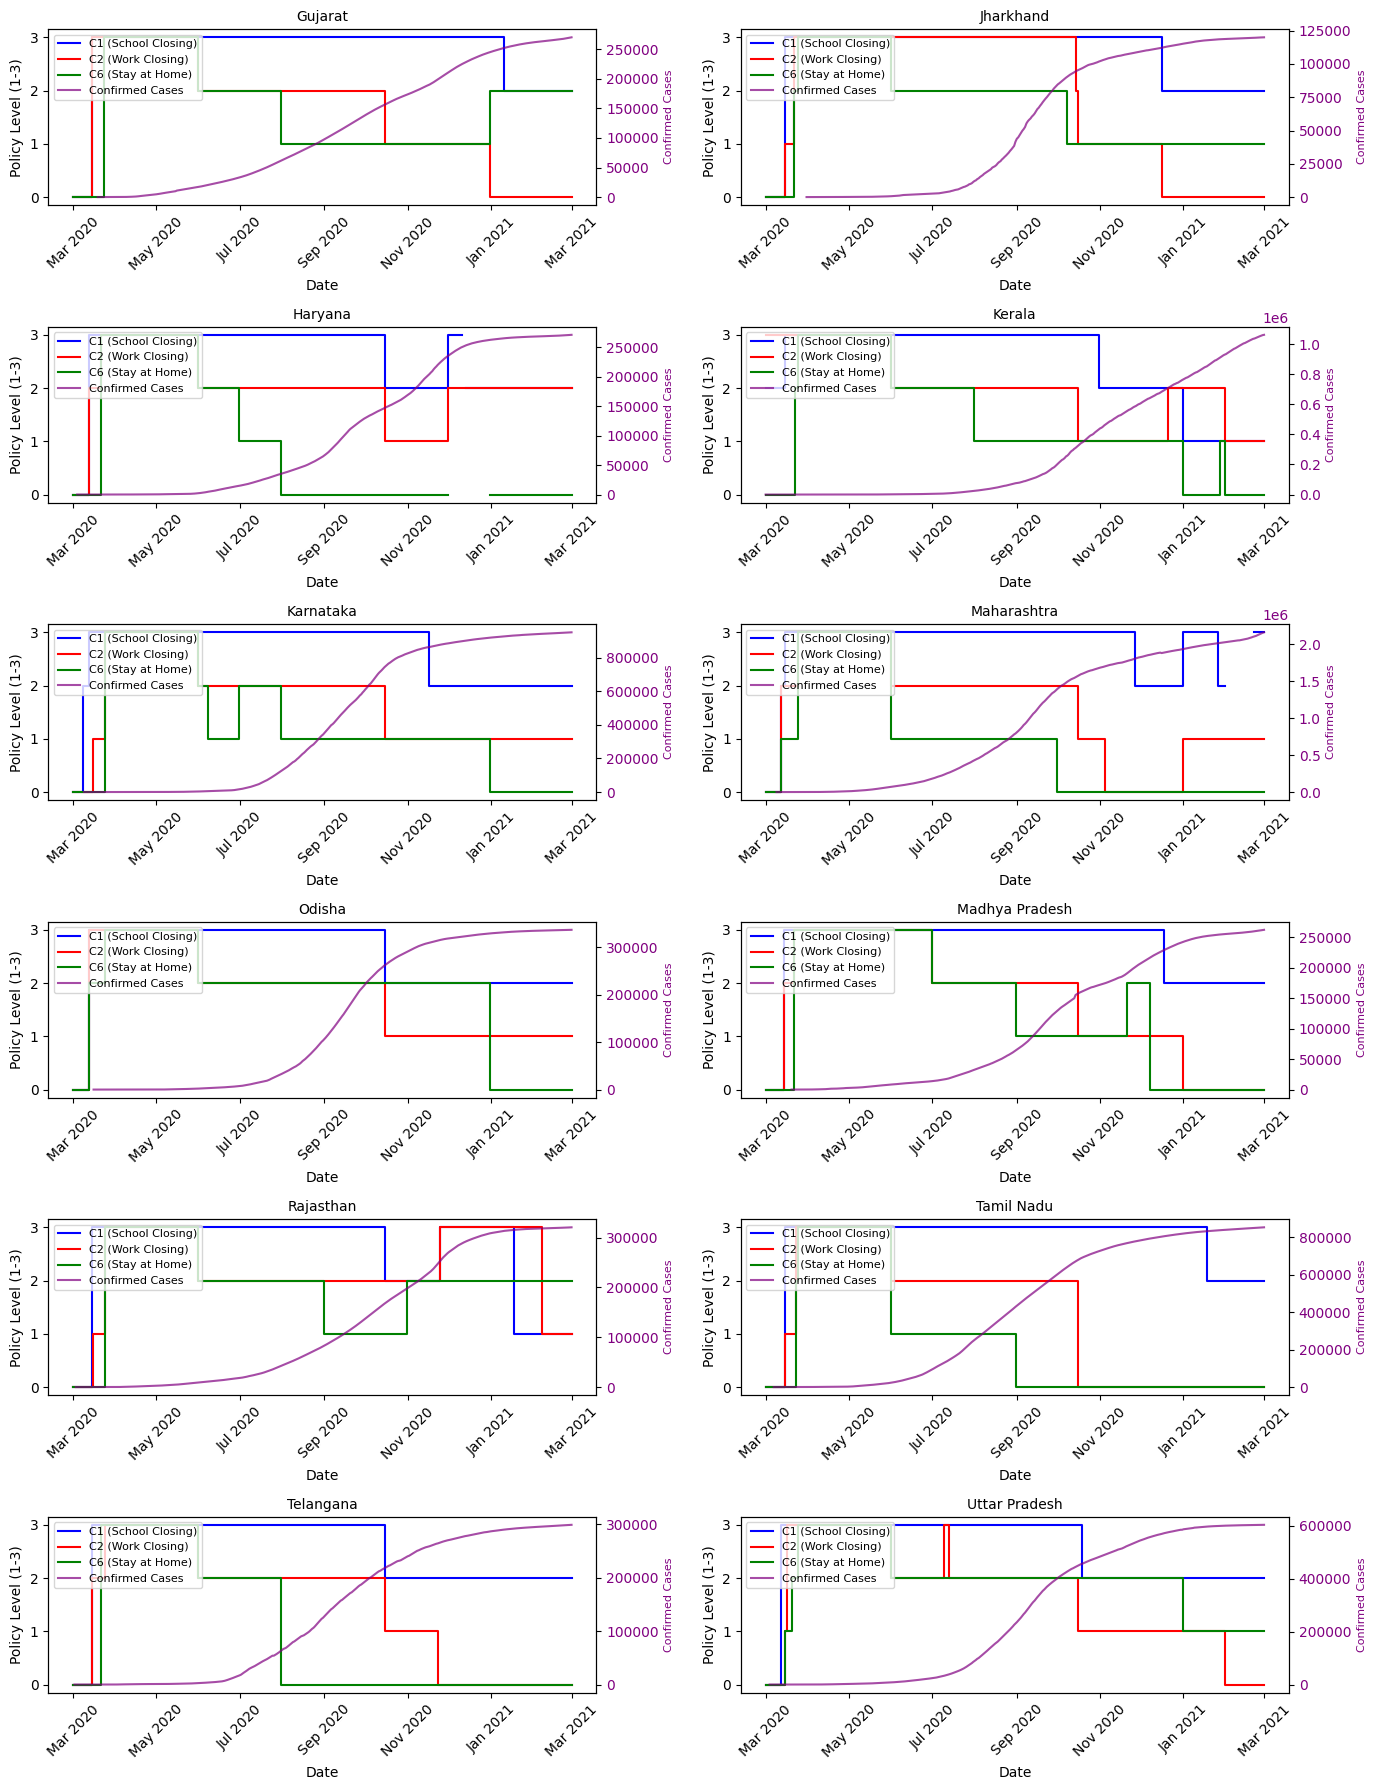

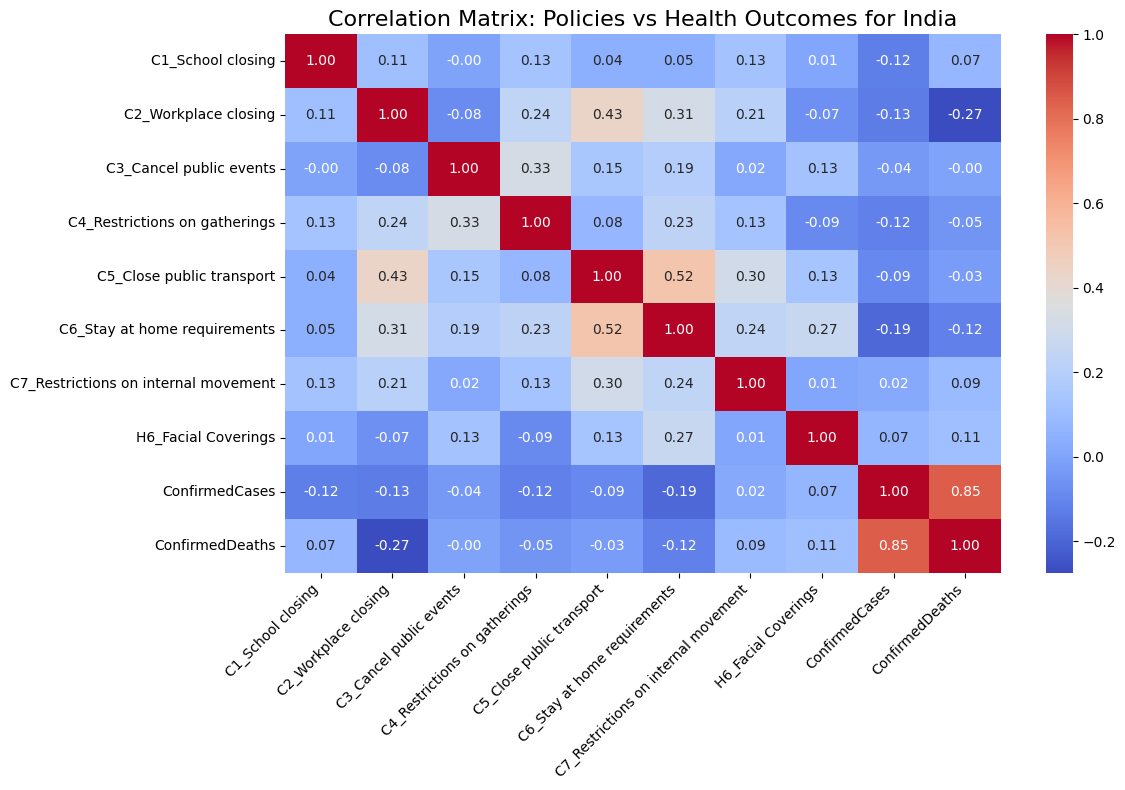

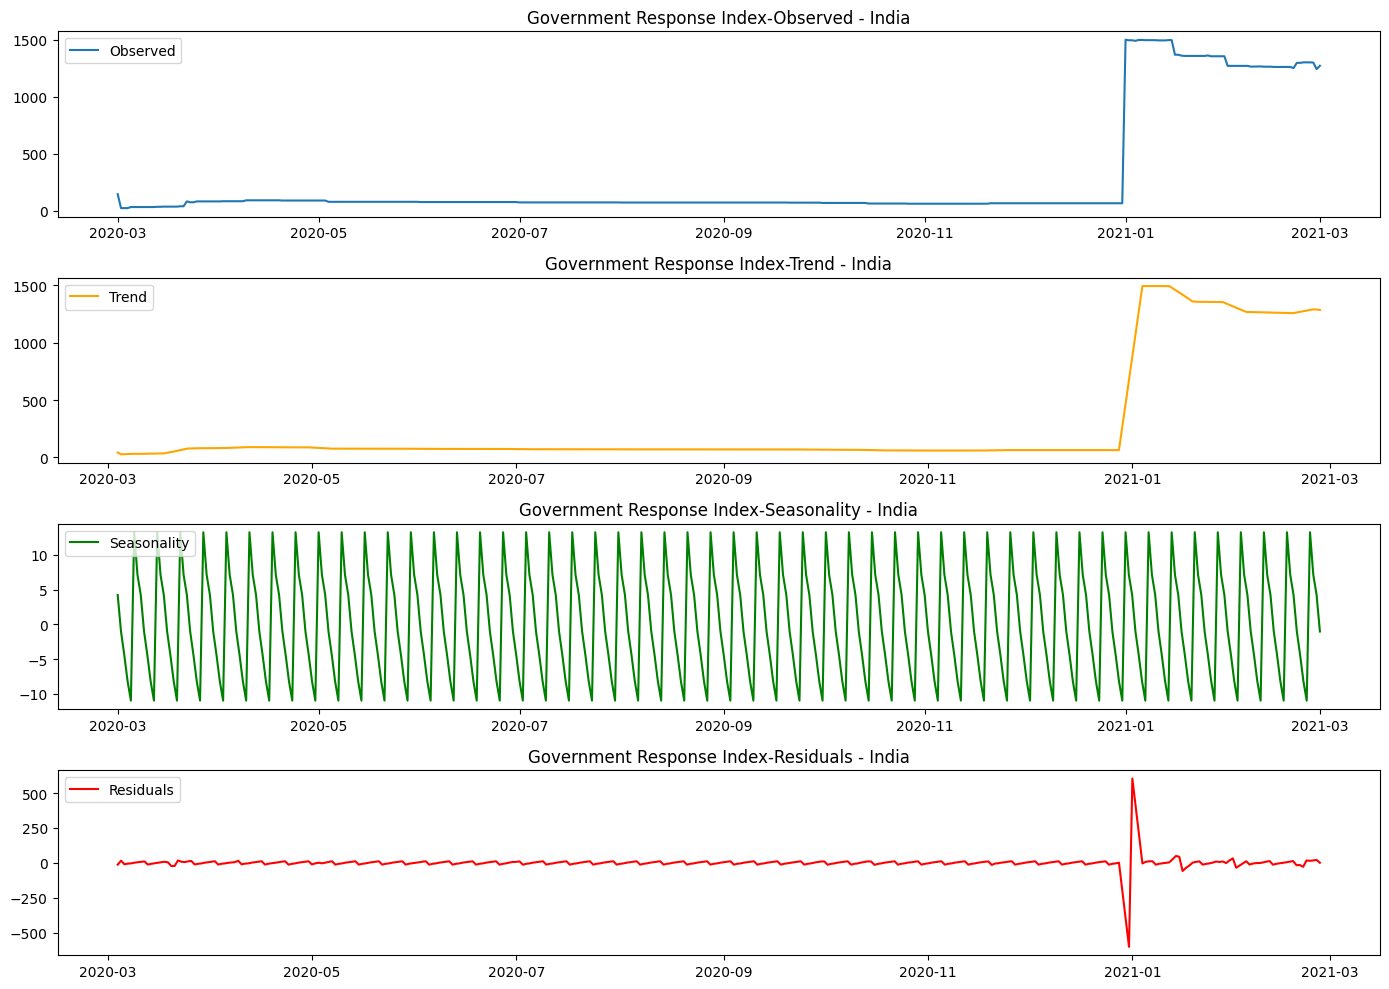

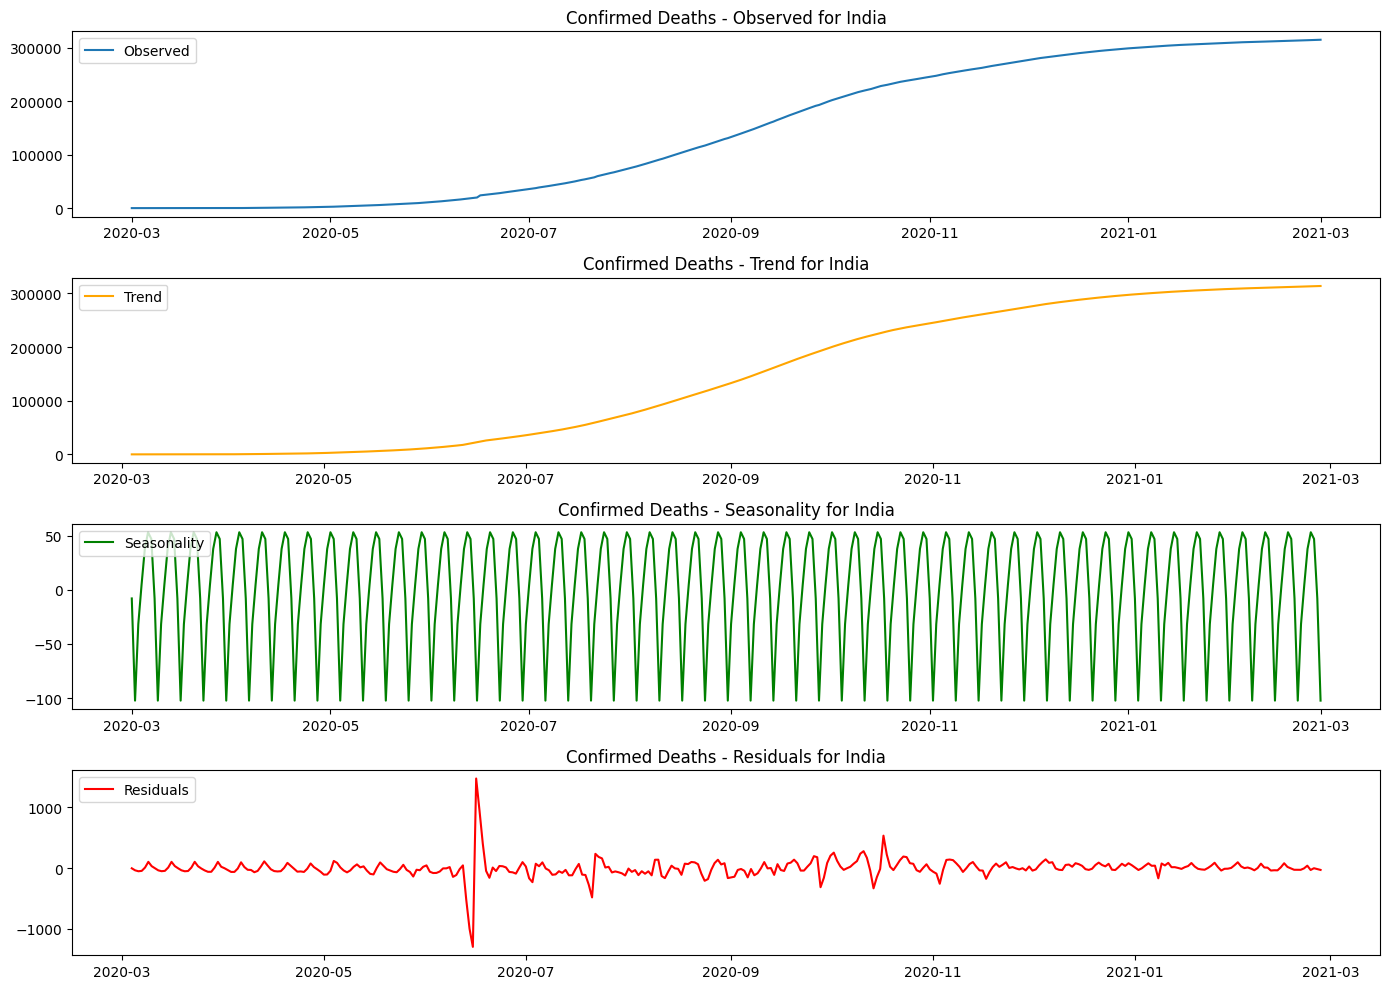

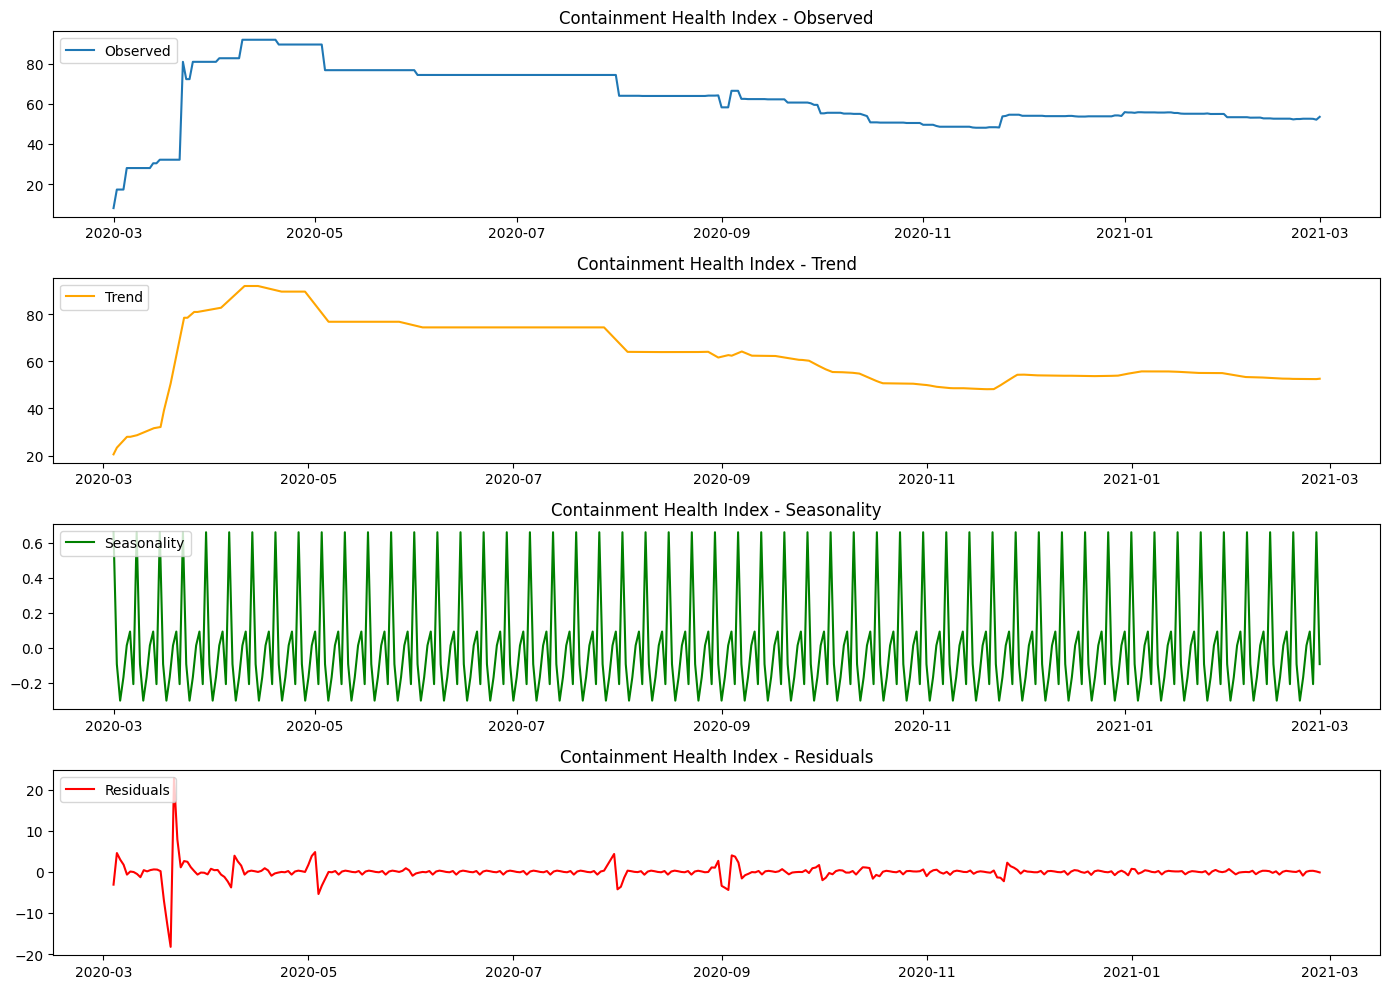

Deaths Trend Component Summary:
count       360.000000
mean     144110.648016
std      122317.783508
min           0.000000
25%       11630.357143
50%      130003.928571
75%      273629.785714
max      313890.857143
Name: trend, dtype: float64

Containment Index Trend Component Summary:
count    360.000000
mean      62.926845
std       14.188977
min       20.532571
25%       53.756536
50%       61.700615
75%       74.400000
max       91.960000
Name: trend, dtype: float64


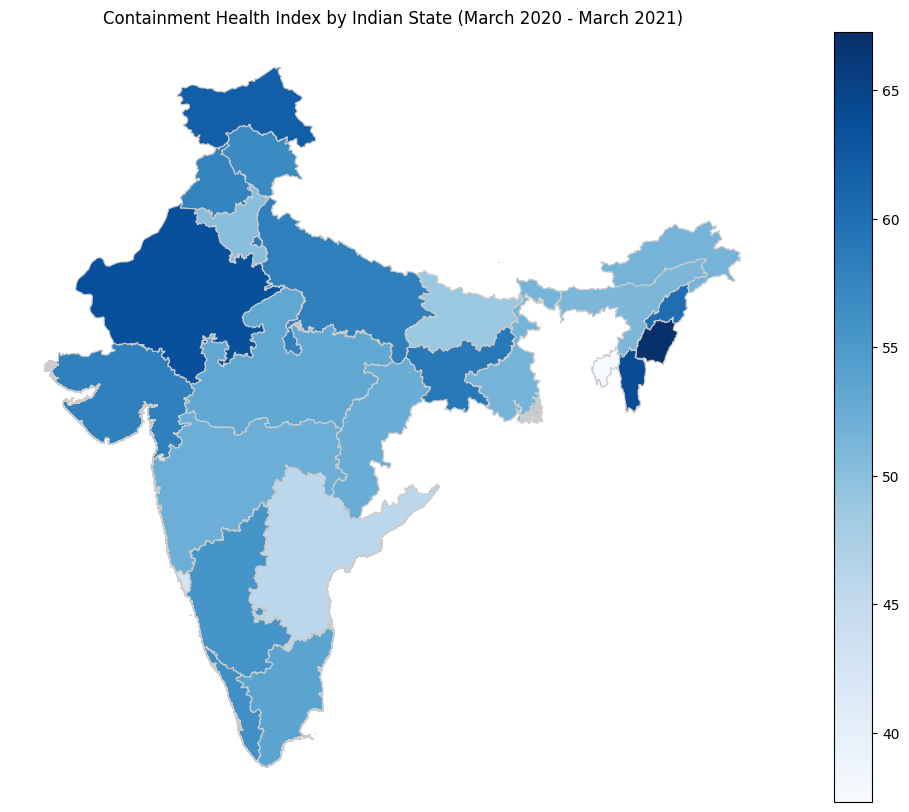

In [1]:
#df.isnull().sum()
#check missing data for a column: df[column_name].isnull()
#dropna()
#dropna(thresh=10) - have at least 10 is null values
#dropna(axis) - drop either the column or row
#Mean val: df[column].mean()
#Median val: df[column].median()
#Mode val: df[column].mode()
#dataframe.duplicated() or dataframe.duplicated().any() - finds duplicate data
#dataframe[colume].isUnique
#Outliers - find standard deviation and IQ Range
from google.colab import files
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd

uploaded = files.upload()

df = pd.read_csv("Data - India.csv", parse_dates=['Date'])

df['Date'] = pd.to_datetime(df['Date'])

start_date = '2020-03-01'
end_date = '2021-03-01'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

if df['Date'].isna().any():
    print("Invalid dates found. Correct them before plotting!")

columns_to_drop = [
    'E1_Flag','H1_Flag', 'H7_Flag', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures',
    'E4_International support', 'M1_Wildcard', 'V2D_Medically/ clinically vulnerable (Non-elderly)',
    'EconomicSupportIndexForDisplay'
]
df = df.drop(columns=columns_to_drop)

print(df.head())
print(df.info())

print(df.describe())

df.isnull().sum()
df.duplicated()

subset_states = [
    'Gujarat', 'Jharkhand', 'Haryana', 'Kerala', 'Karnataka',
    'Maharashtra', 'Odisha', 'Madhya Pradesh','Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh'
]
subset_data = df[df['RegionName'].isin(subset_states)]

n_states = len(subset_states)
rows = (n_states // 2) + (n_states % 2)
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(14, rows * 3))
axes = axes.flatten()

for i, state in enumerate(subset_states):
    ax = axes[i]
    state_data = subset_data[subset_data['RegionName'] == state]

    if not state_data.empty:
        ax.step(state_data['Date'], state_data['C1_School closing'], label="C1 (School Closing)", color="blue", where="mid")
        ax.step(state_data['Date'], state_data['C2_Workplace closing'], label="C2 (Work Closing)", color="red", where="mid")
        ax.step(state_data['Date'], state_data['C6_Stay at home requirements'], label="C6 (Stay at Home)", color="green", where="mid")

        ax2 = ax.twinx()
        ax2.plot(state_data['Date'], state_data['ConfirmedCases'], label="Confirmed Cases", color="purple", linestyle='-', alpha=0.7)
        ax2.set_ylabel("Confirmed Cases", color="purple", fontsize=8)
        ax2.tick_params(axis='y', labelcolor="purple")

    else:
        ax.text(0.5, 0.5, "No data available", fontsize=12, ha='center', va='center')

    ax.set_title(state, fontsize=10)
    ax.set_ylabel("Policy Level (1-3)")
    ax.set_xlabel("Date")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.tick_params(axis='x', rotation=45)
    ax.legend(fontsize=8)

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc="upper left")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

state_data = df.dropna(subset=['RegionName'])
state_filtered_data = state_data[
    (state_data['Date'] >= pd.to_datetime('2020-03-01')) & (state_data['Date'] <= pd.to_datetime('2021-03-31'))
]

state_aggregated = state_filtered_data.groupby('RegionName').agg({
    'ContainmentHealthIndexForDisplay': 'mean',
    'ConfirmedCases': 'max',
    'ConfirmedDeaths': 'max'
}).reset_index()

state_aggregated['CaseFatalityRate'] = state_aggregated['ConfirmedDeaths'] / state_aggregated['ConfirmedCases']
state_aggregated = state_aggregated.sort_values(by='ContainmentHealthIndexForDisplay', ascending=False).head(20)

top_states = state_aggregated['RegionName']
top_states_data = state_filtered_data[state_filtered_data['RegionName'].isin(top_states)]

correlation_data = top_states_data[
    [
        'C1_School closing', 'C2_Workplace closing', 'C3_Cancel public events',
        'C4_Restrictions on gatherings', 'C5_Close public transport',
        'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'H6_Facial Coverings',
        'ConfirmedCases', 'ConfirmedDeaths'
    ]
]

correlation_data = correlation_data.dropna()

correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
    xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns
)
plt.title('Correlation Matrix: Policies vs Health Outcomes for India', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

subset_data = df[['Date', 'GovernmentResponseIndexForDisplay']].groupby('Date').sum().reset_index()

#the time series
decomposition = seasonal_decompose(subset_data.set_index('Date')['GovernmentResponseIndexForDisplay'], model='additive')

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.title('Government Response Index-Observed - India')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.title('Government Response Index-Trend - India')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Government Response Index-Seasonality - India')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Government Response Index-Residuals - India')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

df_grouped = df.groupby('Date').agg({
    'ConfirmedDeaths': 'sum',
    'ContainmentHealthIndex': 'mean'
}).reset_index()

df_grouped = df_grouped.set_index('Date').resample('D').agg({
    'ConfirmedDeaths': 'sum',
    'ContainmentHealthIndex': 'mean'
}).reset_index()

decomposition_deaths = seasonal_decompose(df_grouped.set_index('Date')['ConfirmedDeaths'], model='additive')

decomposition_index = seasonal_decompose(df_grouped.set_index('Date')['ContainmentHealthIndex'], model='additive')

plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition_deaths.observed, label='Observed')
plt.title('Confirmed Deaths - Observed for India')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition_deaths.trend, label='Trend', color='orange')
plt.title('Confirmed Deaths - Trend for India')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition_deaths.seasonal, label='Seasonality', color='green')
plt.title('Confirmed Deaths - Seasonality for India')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition_deaths.resid, label='Residuals', color='red')
plt.title('Confirmed Deaths - Residuals for India')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Plot the components for ContainmentHealthIndex
plt.figure(figsize=(14, 10))

plt.subplot(411)
plt.plot(decomposition_index.observed, label='Observed')
plt.title('Containment Health Index - Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition_index.trend, label='Trend', color='orange')
plt.title('Containment Health Index - Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition_index.seasonal, label='Seasonality', color='green')
plt.title('Containment Health Index - Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition_index.resid, label='Residuals', color='red')
plt.title('Containment Health Index - Residuals')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Deaths Trend Component Summary:")
print(decomposition_deaths.trend.describe())
print("\nContainment Index Trend Component Summary:")
print(decomposition_index.trend.describe())

df = pd.read_csv('Data - India.csv', parse_dates=['Date'])

start_date = '2020-03-01'
end_date = '2021-03-01'
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

drop_columns = ['C1M_Flag', 'C2M_Flag', 'C3M_Flag', 'C4M_Flag', 'C5M_Flag', 'C6M_Flag', 'C7M_Flag',
                'E1_Flag', 'H1_Flag', 'H7_Flag', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures',
                'E4_International support', 'H8M_Protection of elderly people', 'M1_Wildcard', 'MajorityVaccinated',
                'EconomicSupportIndex', 'EconomicSupportIndex_ForDisplay']
existing_columns = [col for col in drop_columns if col in df.columns]
df = df.drop(columns=existing_columns)

state_data = df.dropna(subset=['RegionName'])
state_filtered_data = state_data[(state_data['Date'] >= pd.to_datetime('2020-03-01')) &
                                 (state_data['Date'] <= pd.to_datetime('2021-03-31'))]

state_aggregated = state_filtered_data.groupby('RegionName').agg({
    'ContainmentHealthIndex': 'mean',
    'ConfirmedCases': 'max',
    'ConfirmedDeaths': 'max'
}).reset_index()

state_aggregated['CaseFatalityRate'] = state_aggregated['ConfirmedDeaths'] / state_aggregated['ConfirmedCases']

india_states = gpd.read_file('https://raw.githubusercontent.com/geohacker/india/master/state/india_state.geojson')


india_states = india_states.rename(columns={'NAME_1': 'RegionName'})  

map_data = india_states.merge(state_aggregated, on='RegionName', how='left')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

column_to_plot = 'ContainmentHealthIndex_Average' if 'ContainmentHealthIndex_Average' in map_data.columns else 'ContainmentHealthIndex'
map_data.plot(column=column_to_plot, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title('Containment Health Index by Indian State (March 2020 - March 2021)')
plt.axis('off')
plt.show()